In [4]:
#Most of this notebook is based on unpublished data, the algorithm is demonstrated on a sample cluster from the Daubar 2019 set

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import metrics
import math as mt
import sklearn

In [6]:
#importing the dispersion function:
def dispersion(ClusterData, x = 'x_coord', y = 'y_coord'):
    '''
    This function calculates the dispersion of a cluster from a pandas dataframe giving the x and y coordinates of .
    The dispersion is defined as the standard deviation of the distance between all possible crater pairs.
    This method gives meaningul results for clusters with more than 3 craters in a cluster.
    It is using the radius of Mars to convert from lat/lon data to metres.

    :param ClusterData: Dataframe containing all craters in clusters
    :type ClusterData: pandas dataframe
    :param x: column name giving the longitude, defaults to 'x_coord'
    :type x: str
    :param y: column name giving the latitude, defaults to 'y_coord'
    :type y: str
    '''    
    Rmars = 3390000 #radius of Mars in metres
    #x and y are the names of the column in ClusterData denoting the x and y coordinates respectively
    #Assumes that x and y are in degrees still!
    df = ClusterData.copy() #create work copy of database
    coord_array = np.array(df[[x, y]]) #create array of xy coordinates for craters in cluster
    sep_list = []
    for n in range(0, len(coord_array)): #iterating over all craters for separation calculation
        for m in range(n+1, len(coord_array)): #calculating seperation ((x2-x1)**2 + (y2 - y1)**2)**0.5 for all combinations
            dx= (coord_array[m,0] - coord_array[n,0]) *Rmars*(np.pi/180)*mt.sin(mt.radians(90 - ((coord_array[m,0]+ coord_array[n,0])/2))) #converting to metres based xy coordinates
            dy = (coord_array[m,1] - coord_array[n,1]) *Rmars*(np.pi/180)
            sep = (dx**2+ dy**2)**0.5
            sep_list.append(sep) #adding all separations to list
    dispersion = np.std(sep_list) #calculating dispersion as standard deviation
    return dispersion, sep_list

In [10]:
#importing test data

df0 = pd.read_excel('DataTables/ESP_013694_2060formatted.xlsx')
ID0 = 'ESP_013694_2060' #clear clustering is observed
#df1 = pd.read_excel('ESP_059292_2030formatted.xlsx', index_col = [0,1])
#ID1 = 'ESP_059292_2030' #clear clustering is observed
#df2 = pd.read_excel('ESP_059387_1605formatted.xlsx', index_col = [0,1])
#ID2 = 'ESP_059387_1605' #possible clustering
#df3 = pd.read_excel('ESP_059451_1950formatted.xlsx', index_col = [0,1])
#ID3 = 'ESP_059451_1950' #no clustering observed
param = pd.read_excel('DataTables/TestParameters.xlsx', index_col = 0)

In [12]:
#converting the x and y coordinates from degrees to metres:

def converter(df, ID):
    Rmars = 3390000 
    latc = param['central_latitude'].loc[param['HiRise_ID']==ID].values[0]
    lonc = param['central_longitude'].loc[param['HiRise_ID']==ID].values[0]
    df['x_coord_m'] = df['x_coord'].apply(lambda a:(a - latc)*Rmars*(np.pi/180))
    df['y_coord_m'] = df['y_coord'].apply(lambda a:(a - lonc)*Rmars*(np.pi/180)*mt.sin(mt.radians(90 - a)))

#converting the test data:

#converter(df1, ID1)
#converter(df2, ID2)
#converter(df3, ID3)
converter(df0, ID0)

In [13]:
def find_subclustering(df,ID, eps = 11, min_samples = 3):
    '''
    A function to find subclusters in crater clusters by utilizing Density based Spatial Clustering.
    The function is set up to print out a plot of the subclusters and measurements.
    It takes as input a dataframe holding the spatial coordinates for every crater in a cluster and the HiRise ID of the associated image
    The ID is soley needed for the title of the plot.
    The eps gives the largest possible distance between craters to be considered part of a class
    min_samples gives the minimum amount of craters in a class for it to be considered a cluster
    
    To read up on DBSCAN: https://en.wikipedia.org/wiki/DBSCAN and https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
    '''
    #run DBSCAN on the clusters:
    X = df[['x_coord_m', 'y_coord_m']].to_numpy()
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    labels_true = df.index
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    # Number of clusters in labels, ignoring noise if present.
    homogen = metrics.homogeneity_score(labels_true, labels)
    comp = metrics.completeness_score(labels_true, labels)
    V = metrics.v_measure_score(labels_true, labels)
    shil = mt.nan
    davies = mt.nan
    calinski = mt.nan
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Homogeneity: %0.3f" % homogen)
    print("Completeness: %0.3f" % comp)
    print("V-measure: %0.3f" % V)
    if n_clusters_ >1:
        shil = metrics.silhouette_score(X, labels)
        davies  = sklearn.metrics.davies_bouldin_score(X, labels)
        calinski = sklearn.metrics.calinski_harabasz_score(X, labels)
        print("Silhouette Coefficient: %0.3f"
              % shil)
        print("Davies Bouldin score: %0.3f" % davies) #low equals good clustering
        print("Calinski Harabasz score: %0.3f" % calinski) #high equals good clustering
    # Plot result
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Subclustering in %s' %ID)
    plt.show()
    return n_clusters_, n_noise_, homogen, V, shil, davies, calinski

ESP_013694_2060
Estimated number of clusters: 2
Estimated number of noise points: 2
Homogeneity: 0.113
Completeness: 1.000
V-measure: 0.204
Silhouette Coefficient: 0.263
Davies Bouldin score: 0.836
Calinski Harabasz score: 12.699


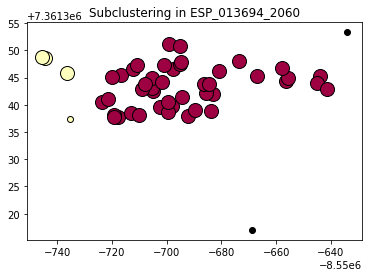

In [14]:
#Running the DBSCAN for the test clusters
print(ID0)
results0 = find_subclustering(df0, ID0 )
#print(ID1)
#results1 = find_subclustering(df1,ID1)
#print(ID2)
#results2 = find_subclustering(df2,ID2)
#print(ID3)
#results4 = find_subclustering(df3,ID3)

In [19]:
#importing and testing largest 3 clusters: (all have at least 150 craters in their cluster)

#df4 = pd.read_excel('C:/Users/jae4518/OneDrive - Imperial College London/HiRise_Images_Clusters/ClustersDataSheet/ESP_046463_2160formatted.xlsx', index_col = [0,1])
#ID4 = 'ESP_046463_2160'
#df5 = pd.read_excel('C:/Users/jae4518/OneDrive - Imperial College London/HiRise_Images_Clusters/ClustersDataSheet/PSP_007009_1905formatted.xlsx', index_col = [0,1])
#ID5 = 'PSP_007009_1905'
#df6 = pd.read_excel('C:/Users/jae4518/OneDrive - Imperial College London/HiRise_Images_Clusters/ClustersDataSheet/ESP_051357_1880formatted.xlsx', index_col = [0,1])
#ID6 = 'ESP_051357_1880'
#converter(df4,ID4)
#converter(df5, ID5)
#converter(df6, ID6)

#print(ID4)
#results4 = find_subclustering(df4,ID4)
#print(ID5)
#results5 = find_subclustering(df5,ID5)
#print(ID6)
#results6 = find_subclustering(df6,ID6)

In [20]:
#find all clusters with observed subclustering:

#df_obs = pd.read_excel('C:/Users/jae4518/OneDrive - Imperial College London/HiRise_Images_Clusters/Analysis/NewClustersObservations.xlsx', index_col = 0)
#df_sub = df_obs.loc[df_obs['Subclustering?'] == True]
#sublist = df_sub['HiRise_ID'].tolist()

In [21]:
#running DBSCAN on the clusters with observed subclustering:

#dic = {'HiRise_ID': ID, 'N_clusters':n_clusters, 'N_noise':n_noise, 'Homogeneity':homogen,
#       'V_measure':V,'Shilhouette_Coefficient':shil, 'Davies_Bouldin_score':davies, 'Calinski_Harabasz_score': calinski}

#df_resultssub = pd.DataFrame(columns=['HiRise_ID', 'N_clusters', 'N_noise', 'Homogeneity', 'V_measure','Shilhouette_Coefficient', 'Davies_Bouldin_score', 'Calinski_Harabasz_score'])
#for ID in sublist:
#    df = pd.read_excel('C:/Users/jae4518/OneDrive - Imperial College London/HiRise_Images_Clusters/ClustersDataSheet/%sformatted.xlsx' %ID, index_col = [0,1])
#    print(ID)
#    converter(df, ID)
#    n_clusters, n_noise, homogen, V,shil, davies, calinski = find_subclustering(df, ID)
#    df_resultssub = df_resultssub.append(dic, ignore_index = True) #adding the results to new results dataframe


In [22]:
#finding all craters with no observed subclustering:

#df_nosub = df_obs.loc[df_obs['Subclustering?'] == False]
#nolist = df_nosub['HiRise_ID'].tolist()

In [23]:
#running DBSCAN on clusters without observed clustering

#df_resultsnosub = pd.DataFrame(columns=['HiRise_ID', 'N_clusters', 'N_noise', 'Homogeneity', 'V_measure','Shilhouette_Coefficient', 'Davies_Bouldin_score', 'Calinski_Harabasz_score'])
#for ID in nolist:
#    df = pd.read_excel('C:/Users/jae4518/OneDrive - Imperial College London/HiRise_Images_Clusters/ClustersDataSheet/%sformatted.xlsx' %ID, index_col = [0,1])
#    print(ID)
#    converter(df, ID)
#    n_clusters, n_noise, homogen, V,shil, davies, calinski = find_subclustering(df,ID)
#   df_resultsnosub = df_resultsnosub.append(dic, ignore_index = True) #adding results to new results dataframe

In [24]:
#Plotting Calinski Harabasz score distribution for observed and not observed 

#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax.hist(df_resultssub['Calinski_Harabasz_score'], 10, density = True,alpha = 0.5, label = 'Observed subclustering')
#ax.hist(df_resultsnosub['Calinski_Harabasz_score'], 10,density = True,alpha = 0.5, label = 'No observed subclustering')
#ax.legend(loc = 'best')
#ax.set_title('Calinski Harabasz score')

In [25]:
#Plotting Davies Bouldin score histogram

#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax.hist(df_resultssub['Davies_Bouldin_score'], 10,density = True, alpha = 0.5, label = 'Observed subclustering')
#ax.hist(df_resultsnosub['Davies_Bouldin_score'], 10,density = True,alpha = 0.5, label = 'No observed subclustering')
#ax.legend(loc = 'best')
#ax.set_title('Davies_Bouldin_score score')

In [26]:
#Plotting V measure histogram

#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax.hist(df_resultssub['V_measure'], 10,density = True, label = 'Observed subclustering', alpha = 0.5)
#ax.hist(df_resultsnosub['V_measure'], 10,density = True, label = 'No observed subclustering', alpha = 0.5)
#ax.legend(loc = 'best')
#ax.set_title('V measure')